In [14]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve


In [2]:
# supprese warning
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# 0. Load Data

In [8]:
# Read the dataset
data = pd.read_csv("data/processed_data/processed_data.csv")

# Check for NaN values in columns
nan_columns = data.columns[data.isna().any()].tolist()
if nan_columns:
    print("Columns with NaN values before imputation:", nan_columns)
    for col in nan_columns:
        if data[col].dtype == 'object':
            # Impute using the most frequent value for categorical columns
            imputer = SimpleImputer(strategy='most_frequent')
        else:
            # Impute using the mean for numerical columns
            imputer = SimpleImputer(strategy='mean')
        # Fit and transform the imputer on the specific column
        data[col] = imputer.fit_transform(data[[col]])[:, 0]  # Accessing the first column of the transformed array
    print("NaN values have been imputed.")
else:
    print("No NaN values in the dataset.")

Columns with NaN values before imputation: ['NUMTRD']
NaN values have been imputed.


In [9]:
# process categorical valuse
label_encoder = LabelEncoder()
data['read_grade'] = label_encoder.fit_transform(data['read_grade'])
data['state'] = label_encoder.fit_transform(data['state'])
data['region'] = label_encoder.fit_transform(data['region'])
data['area'] = label_encoder.fit_transform(data['area'])

In [7]:
# Split train and test
test_set = data[data.date<20230000]
data = data[data.date>=20230000]

In [10]:
# select columns
X = data[['num_chars', 'num_nonwhite_chars', 'num_number', 'feature0_air', 'feature1_climate', 'feature2_conditions', 'feature3_drought', 'feature4_emergency', 'feature5_federal', 'feature6_fire', 'feature7_flooding', 'feature8_hit', 'feature9_hurricane', 'feature10_officials', 'feature11_power', 'feature12_region', 'feature13_residents', 'feature14_service', 'feature15_storms', 'feature16_water', 'feature17_weather', 'feature18_wildfires', 'feature19_winds', 'polarity', 'subjectivity', 'num_sentences', 'num_syllables', 'readability', 'read_grade', 'calc_grade', 'state', 'region', 'area', 'GDP', 'population', 'longitude', 'latitude']]
y = data['drop']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Random Forest

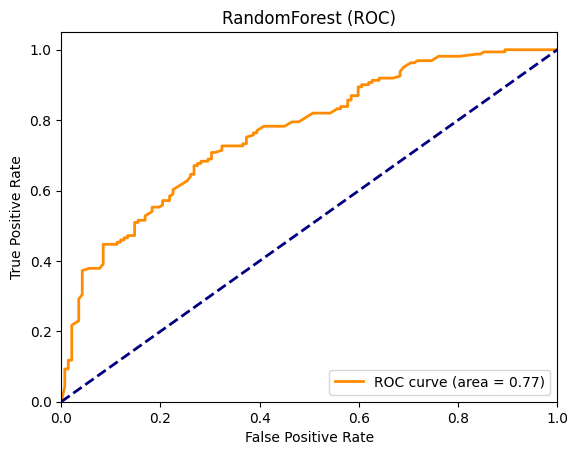

Accuracy: 0.6963696369636964
Recall: 0.6963696369636964
F1 Score: 0.6966610542914513
AUC-ROC Score: 0.7663371533549121


In [12]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test):
    # Initialize and fit the random forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Predict probabilities for each class
    y_probs = rf_classifier.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])  # Assuming y_test contains binary labels 0 and 1
    auc_roc = roc_auc_score(y_test, y_probs[:, 1])  # Compute AUC-ROC score

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RandomForest (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    # Print evaluation metrics
    print("Accuracy:", accuracy_score(y_test, rf_classifier.predict(X_test)))
    print("Recall:", recall_score(y_test, rf_classifier.predict(X_test), average='weighted'))
    print("F1 Score:", f1_score(y_test, rf_classifier.predict(X_test), average='weighted'))
    print("AUC-ROC Score:", auc_roc)

# Train and evaluate random forest classifier
train_and_evaluate_rf(X_train, y_train, X_test, y_test)


In [15]:
def train_and_evaluate_rf_with_cv(X, y, n_splits=5):
    # Initialize Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize lists to store evaluation metrics
    accuracies = []
    recalls = []
    f1_scores = []
    auc_roc_scores = []

    # Iterate over each fold
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize and fit the random forest classifier
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Predict probabilities for each class
        y_probs = rf_classifier.predict_proba(X_test)

        # Compute ROC curve and ROC area for each class
        auc_roc = roc_auc_score(y_test, y_probs[:, 1])

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, rf_classifier.predict(X_test))
        recall = recall_score(y_test, rf_classifier.predict(X_test), average='weighted')
        f1 = f1_score(y_test, rf_classifier.predict(X_test), average='weighted')

        # Append evaluation metrics to lists
        accuracies.append(accuracy)
        recalls.append(recall)
        f1_scores.append(f1)
        auc_roc_scores.append(auc_roc)

    # Compute average evaluation metrics across all folds
    avg_accuracy = np.mean(accuracies)
    avg_recall = np.mean(recalls)
    avg_f1_score = np.mean(f1_scores)
    avg_auc_roc_score = np.mean(auc_roc_scores)

    # Print average evaluation metrics
    print("Average Accuracy:", avg_accuracy)
    print("Average Recall:", avg_recall)
    print("Average F1 Score:", avg_f1_score)
    print("Average AUC-ROC Score:", avg_auc_roc_score)

# Train and evaluate random forest classifier with cross-validation
train_and_evaluate_rf_with_cv(X, y, n_splits=5)


Average Accuracy: 0.6726072607260727
Average Recall: 0.6726072607260727
Average F1 Score: 0.6720934103766673
Average AUC-ROC Score: 0.7343091549543164


# 2. SVM

In [16]:
def train_and_evaluate_svm(X_train, y_train, X_test, y_test):
    # Define the SVM model
    clf = SVC(kernel='rbf')

    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': [0.01, 0.1, 1]
    }

    # Perform GridSearchCV
    grid_search = GridSearchCV(clf, param_grid, scoring='f1_weighted', cv=5)
    grid_search.fit(X_train, y_train)

    # Print best parameters found
    print("Best parameters found:")
    print(grid_search.best_params_)

    # Get the best estimator
    best_clf = grid_search.best_estimator_

    # Make predictions on the test set
    predictions = best_clf.predict(X_test)

    # Evaluate the model
    print("SVM evaluation with optimized parameters:")
    print(classification_report(y_test, predictions))
    print(f"F1 Score: {f1_score(y_test, predictions, average='weighted')}")

# Train and evaluate SVM model with hyperparameter tuning
train_and_evaluate_svm(X_train, y_train, X_test, y_test)


Best parameters found:
{'C': 1, 'gamma': 0.01}
SVM evaluation with optimized parameters:
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       142
           1       0.74      0.63      0.68       161

    accuracy                           0.68       303
   macro avg       0.69      0.69      0.68       303
weighted avg       0.69      0.68      0.68       303

F1 Score: 0.6827540855715485


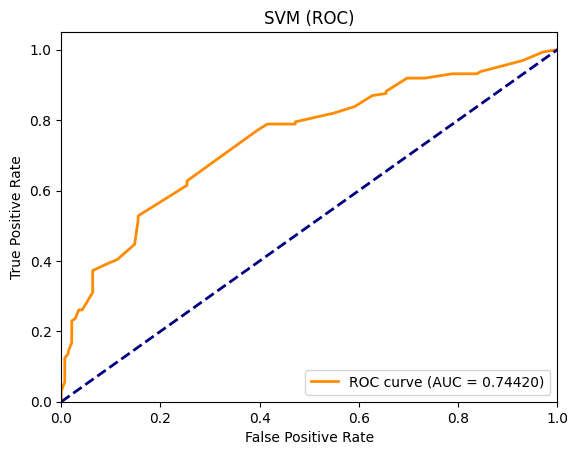

AUC: 0.74420
SVM evaluation with optimized parameters:
              precision    recall  f1-score   support

           0  0.63855      0.74648      0.68831     142.0
           1  0.73723      0.62733      0.67785     161.0

    accuracy                           0.68317     303
   macro avg      0.68789      0.68690      0.68308     303.0
weighted avg      0.69098      0.68317      0.68275     303.0

F1 Score: 0.68275


In [17]:
def train_and_evaluate_svm_with_roc(X_train, y_train, X_test, y_test, best_params):
    # Define the SVM model with the best hyperparameters
    clf = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], probability=True)

    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_probs = clf.predict_proba(X_test)
    y_pred = y_probs[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.5f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('SVM (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    # Print AUC
    print(f"AUC: {auc:.5f}")

    # Evaluate the model
    print("SVM evaluation with optimized parameters:")
    report = classification_report(y_test, clf.predict(X_test), output_dict=True)
    print(f"              precision    recall  f1-score   support\n\n"
          f"           0  {report['0']['precision']:.5f}      {report['0']['recall']:.5f}      {report['0']['f1-score']:.5f}     {report['0']['support']}\n"
          f"           1  {report['1']['precision']:.5f}      {report['1']['recall']:.5f}      {report['1']['f1-score']:.5f}     {report['1']['support']}\n\n"
          f"    accuracy                           {report['accuracy']:.5f}     {len(y_test)}\n"
          f"   macro avg      {report['macro avg']['precision']:.5f}      {report['macro avg']['recall']:.5f}      {report['macro avg']['f1-score']:.5f}     {report['macro avg']['support']}\n"
          f"weighted avg      {report['weighted avg']['precision']:.5f}      {report['weighted avg']['recall']:.5f}      {report['weighted avg']['f1-score']:.5f}     {report['weighted avg']['support']}")

    f1 = f1_score(y_test, clf.predict(X_test), average='weighted')
    print(f"\nF1 Score: {f1:.5f}")

# Train, evaluate, and plot ROC curve for SVM model with best hyperparameters
best_params = {'C': 1, 'gamma': 0.01}
train_and_evaluate_svm_with_roc(X_train, y_train, X_test, y_test, best_params)


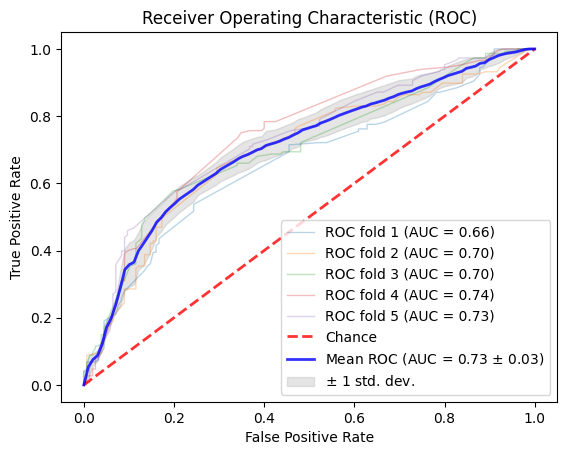

In [18]:
def train_and_evaluate_svm_with_cv(X, y, best_params, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], probability=True)
        clf.fit(X_train, y_train)

        y_probs = clf.predict_proba(X_test)
        y_pred = y_probs[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = roc_auc_score(y_test, y_pred)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = roc_auc_score(y_test, y_pred)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC)')
    ax.legend(loc="lower right")
    plt.show()

# Train and evaluate SVM model with cross-validation
best_params = {'C': 1, 'gamma': 0.01}
train_and_evaluate_svm_with_cv(X, y, best_params)


# 3. XGBOOST

In [ ]:
def train_and_evaluate_xgboost(X_train, y_train, X_test, y_test):
    # Initialize XGBoost classifier
    xgb_classifier = XGBClassifier()

    # Train the classifier
    xgb_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("XGBoost evaluation with detailed class-wise metrics:")
    print(classification_report(y_test, y_pred))

# Train and evaluate XGBoost model
train_and_evaluate_xgboost(X_train, y_train_encoded, X_test, y_test_encoded)

Accuracy: 0.6923076923076923
Recall: 0.6923076923076923
F1 Score: 0.6922824011431606
XGBoost evaluation with detailed class-wise metrics:
              precision    recall  f1-score   support

           0       0.69      0.70      0.70       157
           1       0.69      0.68      0.69       155

    accuracy                           0.69       312
   macro avg       0.69      0.69      0.69       312
weighted avg       0.69      0.69      0.69       312



In [ ]:

def train_and_evaluate_xgboost_with_grid_search(X_train, y_train, X_test, y_test):
    xgb = XGBClassifier(use_label_encoder=False)

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    grid_search = GridSearchCV(xgb, param_grid, scoring='f1_weighted', cv=5, verbose=2)

    grid_search.fit(X_train, y_train)

    print("Best parameters found:")
    print(grid_search.best_params_)

    best_xgb = grid_search.best_estimator_
    predictions = best_xgb.predict(X_test)

    # Evaluate the model with the best parameters
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("XGBoost evaluation with detailed class-wise metrics:")
    print(classification_report(y_test, predictions))

# Train and evaluate XGBoost model with grid search for hyperparameter tuning
train_and_evaluate_xgboost_with_grid_search(X_train, y_train_encoded, X_test, y_test_encoded)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=100; total time=   4.0s
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=100; total time=   1.5s
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=100; total time=   0.8s
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=100; total time=   2.0s
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=100; total time=   4.2s
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=200; total time=   3.8s
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=200; total time=   5.6s
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=200; total time=   2.8s
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=200; total time=   4.2s
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=200; total time=   0.9s
[CV] END colsample_bytree=0.8, max_depth=3, n_estimators=300; total time=   6.3s
[CV] END colsample_bytree=0.8, max_depth=3, n_e

Accuracy: 0.69231
Recall: 0.69231
F1 Score: 0.69231
XGBoost evaluation with detailed class-wise metrics:
              precision    recall  f1-score   support

           0  0.69427      0.69427      0.69427     157
           1  0.69032      0.69032      0.69032     155

    accuracy                           0.69231     312
   macro avg      0.69230      0.69230      0.69230     312
weighted avg      0.69231      0.69231      0.69231     312


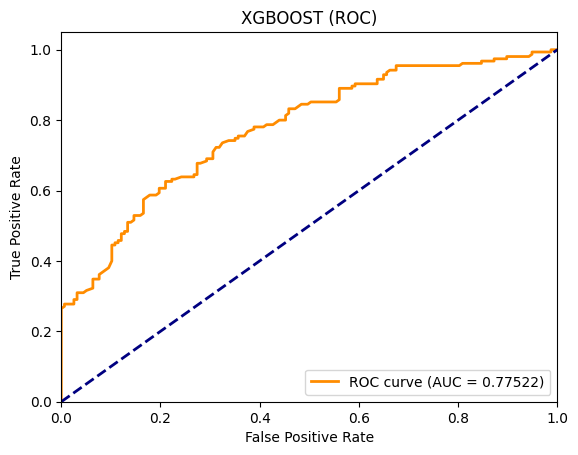

In [ ]:
def train_and_evaluate_best_xgboost_with_roc(X_train, y_train, X_test, y_test):
    # Define the XGBoost model with the best parameters
    best_xgb = XGBClassifier(n_estimators=300, max_depth=5, colsample_bytree=0.9, use_label_encoder=False)

    # Train the model
    best_xgb.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = best_xgb.predict(X_test)
    probabilities = best_xgb.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    # Print evaluation metrics
    print("Accuracy: {:.5f}".format(accuracy))
    print("Recall: {:.5f}".format(recall))
    print("F1 Score: {:.5f}".format(f1))
    print("XGBoost evaluation with detailed class-wise metrics:")
    report = classification_report(y_test, predictions, output_dict=True)
    print(f"              precision    recall  f1-score   support\n\n"
          f"           0  {report['0']['precision']:.5f}      {report['0']['recall']:.5f}      {report['0']['f1-score']:.5f}     {report['0']['support']}\n"
          f"           1  {report['1']['precision']:.5f}      {report['1']['recall']:.5f}      {report['1']['f1-score']:.5f}     {report['1']['support']}\n\n"
          f"    accuracy                           {report['accuracy']:.5f}     {len(y_test)}\n"
          f"   macro avg      {report['macro avg']['precision']:.5f}      {report['macro avg']['recall']:.5f}      {report['macro avg']['f1-score']:.5f}     {report['macro avg']['support']}\n"
          f"weighted avg      {report['weighted avg']['precision']:.5f}      {report['weighted avg']['recall']:.5f}      {report['weighted avg']['f1-score']:.5f}     {report['weighted avg']['support']}")

    # Compute AUC-ROC
    auc_roc = roc_auc_score(y_test, probabilities)

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.5f})'.format(auc_roc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('XGBOOST (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Train and evaluate XGBoost model with best parameters and plot ROC curve
train_and_evaluate_best_xgboost_with_roc(X_train, y_train_encoded, X_test, y_test_encoded)


In [ ]:
def train_and_evaluate_best_xgboost(X_train, y_train, X_test, y_test):
    # Define the XGBoost model with the best parameters
    best_xgb = XGBClassifier(n_estimators=300, max_depth=5, colsample_bytree=0.9, use_label_encoder=False)

    # Train the model
    best_xgb.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = best_xgb.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("XGBoost evaluation with detailed class-wise metrics:")
    print(classification_report(y_test, predictions))

# Train and evaluate XGBoost model with best parameters
train_and_evaluate_best_xgboost(X_train, y_train, X_test, y_test)


Accuracy: 0.6923076923076923
Recall: 0.6923076923076923
F1 Score: 0.6923076923076923
XGBoost evaluation with detailed class-wise metrics:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       157
           1       0.69      0.69      0.69       155

    accuracy                           0.69       312
   macro avg       0.69      0.69      0.69       312
weighted avg       0.69      0.69      0.69       312



# 4. CatBoost

Accuracy: 0.69231
Recall: 0.69231
F1 Score: 0.69223
CatBoost evaluation with detailed class-wise metrics:
              precision    recall  f1-score   support

           0  0.68944      0.70701      0.69811     157
           1  0.69536      0.67742      0.68627     155

    accuracy                           0.69231     312
   macro avg      0.69240      0.69221      0.69219     312
weighted avg      0.69238      0.69231      0.69223     312


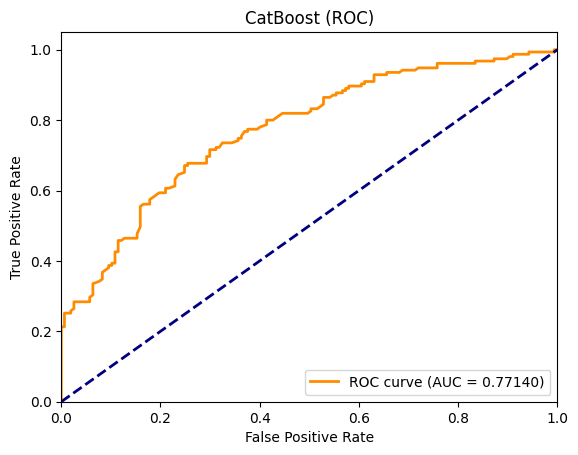

In [ ]:
def train_and_evaluate_catboost_with_roc(X_train, y_train, X_test, y_test):
    # Initialize CatBoost classifier
    catboost_classifier = CatBoostClassifier()

    # Train the classifier
    catboost_classifier.fit(X_train, y_train, verbose=False)

    # Make predictions on the test set
    y_pred = catboost_classifier.predict(X_test)
    probabilities = catboost_classifier.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print evaluation metrics
    print("Accuracy: {:.5f}".format(accuracy))
    print("Recall: {:.5f}".format(recall))
    print("F1 Score: {:.5f}".format(f1))
    print("CatBoost evaluation with detailed class-wise metrics:")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"              precision    recall  f1-score   support\n\n"
          f"           0  {report['0']['precision']:.5f}      {report['0']['recall']:.5f}      {report['0']['f1-score']:.5f}     {report['0']['support']}\n"
          f"           1  {report['1']['precision']:.5f}      {report['1']['recall']:.5f}      {report['1']['f1-score']:.5f}     {report['1']['support']}\n\n"
          f"    accuracy                           {report['accuracy']:.5f}     {len(y_test)}\n"
          f"   macro avg      {report['macro avg']['precision']:.5f}      {report['macro avg']['recall']:.5f}      {report['macro avg']['f1-score']:.5f}     {report['macro avg']['support']}\n"
          f"weighted avg      {report['weighted avg']['precision']:.5f}      {report['weighted avg']['recall']:.5f}      {report['weighted avg']['f1-score']:.5f}     {report['weighted avg']['support']}")

    # Compute AUC-ROC
    auc_roc = roc_auc_score(y_test, probabilities)

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.5f})'.format(auc_roc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('CatBoost (ROC)')
    plt.legend(loc='lower right')
    plt.show()# Train and evaluate CatBoost model with ROC curve
train_and_evaluate_catboost_with_roc(X_train, y_train, X_test, y_test)


# 5. Stacking

Stacking evaluation:
              precision    recall  f1-score   support

           0  0.67273      0.70701      0.68944     157
           1  0.68707      0.65161      0.66887     155

    accuracy                           0.67949     312
   macro avg      0.67990      0.67931      0.67916     312
weighted avg      0.67986      0.67949      0.67922     312

F1 Score: 0.67922
AUC-ROC: 0.76881


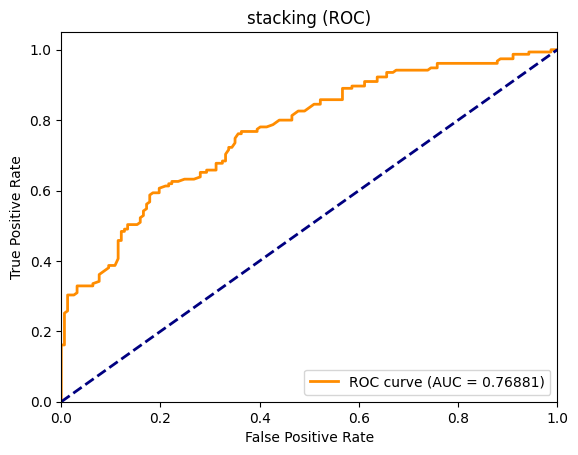

In [ ]:
def train_and_evaluate_stacking(X_train, y_train, X_test, y_test):
    # Initialize scaler
    scaler = StandardScaler(with_mean=False)

    # Initialize models for stacking
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    svm = SVC(kernel='rbf', C=10, gamma=0.01, probability=True)
    xgb = XGBClassifier(use_label_encoder=False, n_estimators=300, max_depth=5, colsample_bytree=0.9)
    catboost = CatBoostClassifier(iterations=100, silent=True)

    # Define estimators for stacking
    estimators = [
        ('rf', rf),
        ('svm', make_pipeline(scaler, svm)),
        ('xgb', xgb),
        ('catboost', catboost)
    ]

    # Initialize stacking classifier with Logistic Regression as final estimator
    clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

    # Fit the stacking classifier
    clf.fit(X_train, y_train)

    # Make predictions and calculate probabilities
    predictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print("Stacking evaluation:")
    report = classification_report(y_test, predictions, output_dict=True)
    print(f"              precision    recall  f1-score   support\n\n"
          f"           0  {report['0']['precision']:.5f}      {report['0']['recall']:.5f}      {report['0']['f1-score']:.5f}     {report['0']['support']}\n"
          f"           1  {report['1']['precision']:.5f}      {report['1']['recall']:.5f}      {report['1']['f1-score']:.5f}     {report['1']['support']}\n\n"
          f"    accuracy                           {report['accuracy']:.5f}     {len(y_test)}\n"
          f"   macro avg      {report['macro avg']['precision']:.5f}      {report['macro avg']['recall']:.5f}      {report['macro avg']['f1-score']:.5f}     {report['macro avg']['support']}\n"
          f"weighted avg      {report['weighted avg']['precision']:.5f}      {report['weighted avg']['recall']:.5f}      {report['weighted avg']['f1-score']:.5f}     {report['weighted avg']['support']}")

    f1 = f1_score(y_test, predictions, average='weighted')
    print(f"\nF1 Score: {f1:.5f}")

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_test, probabilities)
    print(f"AUC-ROC: {auc_roc:.5f}")

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.5f})'.format(auc_roc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('stacking (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Train and evaluate stacking model
train_and_evaluate_stacking(X_train, y_train, X_test, y_test)


# 6. Voting

Majority Vote evaluation:
              precision    recall  f1-score   support

           0  0.67879      0.71338      0.69565     157
           1  0.69388      0.65806      0.67550     155

    accuracy                           0.68590     312
   macro avg      0.68633      0.68572      0.68557     312
weighted avg      0.68628      0.68590      0.68564     312

F1 Score: 0.68564
AUC-ROC: 0.76943


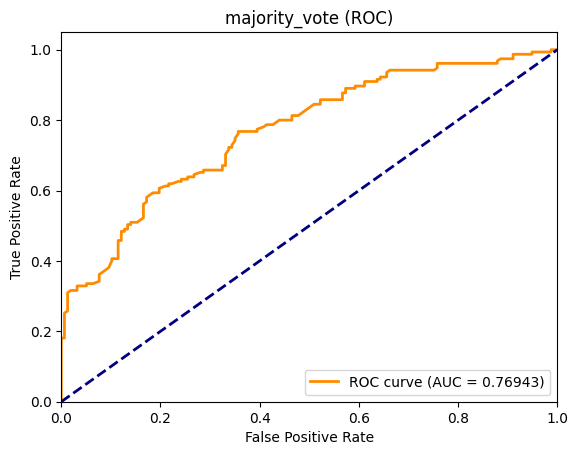

In [ ]:
def train_and_evaluate_majority_vote(X_train, y_train, X_test, y_test):
    # Initialize base models
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    svm = SVC(kernel='rbf', C=10, gamma=0.01, probability=True)
    xgb = XGBClassifier(use_label_encoder=False, n_estimators=300, max_depth=5, colsample_bytree=0.9)
    catboost = CatBoostClassifier(iterations=100, silent=True)

    # Define VotingClassifier
    clf = VotingClassifier(estimators=[
        ('rf', rf),
        ('svm', svm),
        ('xgb', xgb),
        ('catboost', catboost)
    ], voting='soft')  # Set Voting method to 'soft', use probability for voting

    # Train VotingClassifier
    clf.fit(X_train, y_train)

    # Make predictions and calculate probabilities
    predictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print("Majority Vote evaluation:")
    report = classification_report(y_test, predictions, output_dict=True)
    print(f"              precision    recall  f1-score   support\n\n"
          f"           0  {report['0']['precision']:.5f}      {report['0']['recall']:.5f}      {report['0']['f1-score']:.5f}     {report['0']['support']}\n"
          f"           1  {report['1']['precision']:.5f}      {report['1']['recall']:.5f}      {report['1']['f1-score']:.5f}     {report['1']['support']}\n\n"
          f"    accuracy                           {report['accuracy']:.5f}     {len(y_test)}\n"
          f"   macro avg      {report['macro avg']['precision']:.5f}      {report['macro avg']['recall']:.5f}      {report['macro avg']['f1-score']:.5f}     {report['macro avg']['support']}\n"
          f"weighted avg      {report['weighted avg']['precision']:.5f}      {report['weighted avg']['recall']:.5f}      {report['weighted avg']['f1-score']:.5f}     {report['weighted avg']['support']}")

    f1 = f1_score(y_test, predictions, average='weighted')
    print(f"\nF1 Score: {f1:.5f}")

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_test, probabilities)
    print(f"AUC-ROC: {auc_roc:.5f}")

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.5f})'.format(auc_roc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('majority_vote (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Train and evaluate the Majority Vote model
train_and_evaluate_majority_vote(X_train, y_train, X_test, y_test)
